## Tranformer for stock prediction

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install yfinance
!pip install tensorflow
!pip install matplotlib
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Setting model parameter

In [3]:
import pandas as pd
from datetime import datetime
import yfinance as yf
EPOCHS = 200
BATCH_SIZE = 32
TIME_STEPS = 40
KEY_DIM = 32
VALUE_DIM = 32
N_HEAD = 8
FF_DIM = 32
MEAN = 10
STOCK_TICKER = 'IBM' # Ticker of company
STOCK_START_DATE = pd.to_datetime('1992-01-01')     # Train data from start date to validation date
STOCK_END_DATE = pd.to_datetime('2022-01-04')
STOCK_TRAIN_PER = 0.7
STOCK_TEST_PER = 0.2
# STOCK VALIDATION 0.1 percentage
FEATURE = ["Open", 'High', 'Low', 'Close', 'Volume']
CHECKPOINT_FOLDER = "/content/drive/My Drive/Colab Notebooks/checkpoint/base-tranformer-40-timestep"

### Read data and split data to train and test

In [4]:

print("Train Data From: " + STOCK_START_DATE.strftime("%Y-%m-%d"), end=" ")
print('To: ' + STOCK_END_DATE.strftime("%Y-%m-%d"))
df = yf.download([STOCK_TICKER], start=STOCK_START_DATE, end=STOCK_END_DATE)
df.head()

Train Data From: 1992-01-01 To: 2022-01-04
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1992-01-02,21.271511,21.659895,21.241634,21.570269,10.866608,7451286
1992-01-03,21.570269,21.779398,21.510515,21.600143,10.881655,6069310
1992-01-06,21.749521,22.257408,21.719646,22.048279,11.107419,9198524
1992-01-07,21.988527,22.645794,21.958652,22.615917,11.393380,8255032
1992-01-08,22.466539,22.705545,22.048279,22.078156,11.122464,10526526


### Moving Average closing price

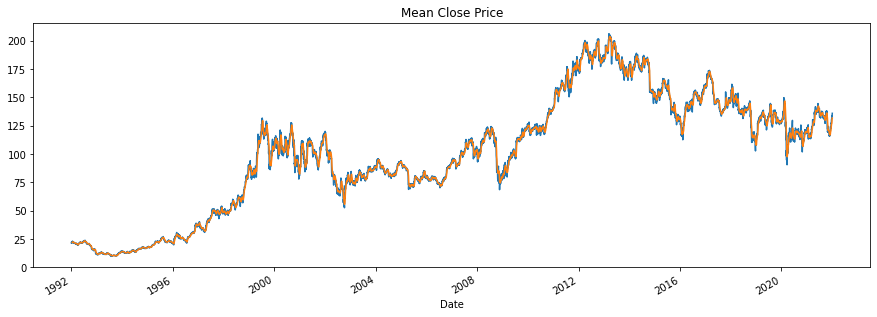

In [5]:
import matplotlib.pyplot as plt
# Apply moving average with a window of MEAN days to all columns
df_mean = df[FEATURE].rolling(MEAN).mean() 
# Drop all rows with NaN values
df_mean.dropna(how='any', axis=0, inplace=True)
plt.figure(figsize=(15, 5))
df['Close'].plot(title="Close Price")
df_mean['Close'].plot(title="Mean Close Price")

### Calculate percentage change for all columns

In [6]:

df_mean['Open'] = df_mean['Open'].pct_change() # Create arithmetic returns column
df_mean['High'] = df_mean['High'].pct_change() # Create arithmetic returns column
df_mean['Low'] = df_mean['Low'].pct_change() # Create arithmetic returns column
df_mean['Close'] = df_mean['Close'].pct_change() # Create arithmetic returns column
df_mean['Volume'] = df_mean['Volume'].pct_change()
df_mean.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

### Data distribution

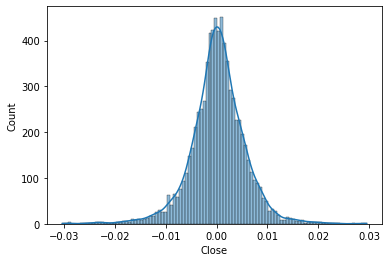

In [7]:
import seaborn as sns
sns.histplot(df_mean['Close'], kde=True)

### Split data

In [8]:
times = sorted(df_mean.index.values)
train_index = times[int(STOCK_TRAIN_PER*len(times))]
test_index = times[-int(STOCK_TEST_PER*len(times))]
df_train = df_mean[df_mean.index < train_index].copy()
df_test = df_mean[df_mean.index >= test_index].copy()
df_val = df_mean[(df_mean.index < test_index) & (df_mean.index >= train_index)].copy()

print('Training data shape: {}'.format(df_train.shape))
print('Validation data shape: {}'.format(df_val.shape))
print('Testing data shape: {}'.format(df_test.shape))

Training data shape: (5284, 5)
Validation data shape: (756, 5)
Testing data shape: (1509, 5)


### Plot daily changes of close prices and volume

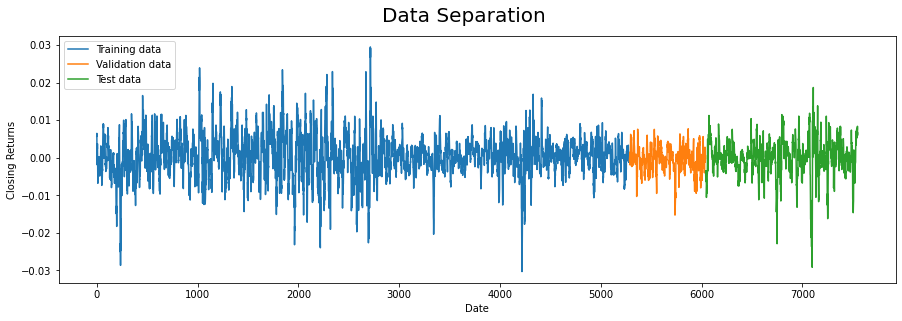

In [9]:
import numpy as np
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.92)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(df_train.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(df_train.shape[0], 
                   df_train.shape[0]+df_val.shape[0]), df_val['Close'], label='Validation data')
ax1.plot(np.arange(df_train.shape[0] + df_val.shape[0], 
                   df_train.shape[0]+df_val.shape[0] +df_test.shape[0]), df_test['Close'], label='Test data')

ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Returns')


plt.legend(loc='best')

### Normalization

In [10]:
from sklearn.preprocessing import MinMaxScaler
'''Normalize price columns'''
scaler = MinMaxScaler()
scaler.fit(df_train[FEATURE])
train_scaled = scaler.transform(df_train[FEATURE])
val_scaled = scaler.transform(df_val[FEATURE])
test_scaled = scaler.transform(df_test[FEATURE])
print(type(train_scaled))

<class 'numpy.ndarray'>


### Create data label by time sequence

In [11]:
def create_data_label(data_train, step=60):
    """ Serialize data by slide window and generate labels after each time step
        default timesteps is 60 day
        param:
          data_train - numpy.ndarray with shape (length, 5)
    """
    upper = data_train.shape[0]
    if step >= upper:
        print("step is greater than data")
        return
    x_train = []
    y_train = []
    for i in range(step, upper):
        x_train.append(data_train[i - step:i])
        y_train.append(data_train[i][3])    # (Close price) is label
    x_train, y_train = np.array(x_train), np.array(y_train)
    return x_train, y_train
# Serialize data and generate labels for train data
x_train, y_train = create_data_label(train_scaled, TIME_STEPS)
x_validation, y_validation = create_data_label(val_scaled, TIME_STEPS)
x_test, y_test = create_data_label(test_scaled, TIME_STEPS)
print('Shape Of X_Train Data :')
print(x_train.shape)
print('Shape of X_Validation Data :')
print(x_validation.shape)
print('Shape of X_Test Data :')
print(x_test.shape)

Shape Of X_Train Data :
(5244, 40, 5)
Shape of X_Validation Data :
(716, 40, 5)
Shape of X_Test Data :
(1469, 40, 5)


### TimeVector Model

In [12]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import tensorflow as tf

class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
        self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
        
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)



In [13]:
import tensorflow as tf
def orthogonality_regularize(weight):
    heads = len(weight)
    n_weight = tf.convert_to_tensor(weight, dtype=tf.float32)
    normalize_weight = tf.linalg.normalize(n_weight)[0]
    regulation = tf.matmul(normalize_weight, normalize_weight, transpose_b=True)
    t = regulation - tf.eye(heads)
    loss = tf.norm(t, ord="fro", axis=(0,1))
    return loss/(heads)/(heads-1)/BATCH_SIZE

### Tensorflow

In [14]:
class SingleAttention(Layer):
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

    def build(self, input_shape):
        self.query = Dense(self.d_k,
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')

        self.key = Dense(self.d_k,
                         input_shape=input_shape,
                         kernel_initializer='glorot_uniform',
                         bias_initializer='glorot_uniform')

        self.value = Dense(self.d_v,
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')

    def call(self, inputs):  # inputs = (in_seq, in_seq, in_seq)
        q = self.query(inputs[0])
        k = self.key(inputs[1])

        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)

        v = self.value(inputs[2])
        attn_out = tf.matmul(attn_weights, v)
        return attn_out, self.value.kernel

#############################################################################


class MultiAttention(Layer):
    def __init__(self, d_k, d_v, n_heads):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.attn_heads = list()

    def build(self, input_shape):
        for n in range(self.n_heads):
            self.attn_heads.append(SingleAttention(self.d_k, self.d_v))

        # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7
        self.linear = Dense(input_shape[0][-1],
                            input_shape=input_shape,
                            kernel_initializer='glorot_uniform',
                            bias_initializer='glorot_uniform')


    def call(self, inputs):
        attn = []
        reg_weight = []
        for i in range(self.n_heads):
          out, weight = self.attn_heads[i](inputs)
          attn.append(out)
          # reg_weight.append(tf.reshape(weight, [-1]))
        concat_attn = tf.concat(attn, axis=-1)
        multi_linear = self.linear(concat_attn)
        # self.add_loss(orthogonality_regularize(reg_weight))
        return multi_linear

#############################################################################


class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.attn_heads = list()
        self.dropout_rate = dropout

    def build(self, input_shape):
        self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
        self.attn_dropout = Dropout(self.dropout_rate)
        self.attn_normalize = LayerNormalization(
            input_shape=input_shape, epsilon=1e-6)

        self.ff_net = Sequential([
            tf.keras.layers.Dense(self.ff_dim, activation='relu'),
            tf.keras.layers.Dense(input_shape[0][-1])
        ])
        self.ff_dropout = Dropout(self.dropout_rate)
        self.ff_normalize = LayerNormalization(
            input_shape=input_shape, epsilon=1e-6)

    def call(self, inputs):  # inputs = (in_seq, in_seq, in_seq)
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)

        ff_layer = self.ff_net(attn_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(attn_layer + ff_layer)
        return ff_layer


### Create Model

In [15]:
# from tensorflow.keras.utils import plot_model
def create_model():
    time_embedding = Time2Vector(TIME_STEPS)
    attn_layer1 = TransformerEncoder(KEY_DIM, VALUE_DIM, N_HEAD, FF_DIM)
    attn_layer2 = TransformerEncoder(KEY_DIM, VALUE_DIM, N_HEAD, FF_DIM)
    attn_layer3 = TransformerEncoder(KEY_DIM, VALUE_DIM, N_HEAD, FF_DIM)

    '''Construct model'''
    in_seq = Input(shape=(TIME_STEPS, 5))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(1, activation='linear')(x)

    model = Model(inputs=in_seq, outputs=out)
    model.compile(loss='mse', optimizer='adam', metrics=["mse", tf.keras.metrics.RootMeanSquaredError("rmse"), 'mae'])
    return model


model = create_model()
model.summary()
# plot_model(model, to_file='./img/model_tranformer.png', show_shapes=True,
#                               show_layer_names=True)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 5)]      0           []                               
                                                                                                  
 time2_vector (Time2Vector)     (None, 40, 2)        160         ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 40, 7)        0           ['input_1[0][0]',                
                                                                  'time2_vector[0][0]']           
                                                                                                  
 transformer_encoder (Transform  (None, 40, 7)       8458        ['concatenate[0][0]',        

### Train model

In [16]:
import tensorflow as tf
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(x_validation, y_validation)
                    # ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)]
                    )
model.save(CHECKPOINT_FOLDER)
# Print evaluation metrics for all datasets
train_eval = model.evaluate(x_train, y_train, verbose=0)
val_eval = model.evaluate(x_validation, y_validation, verbose=0)
test_eval = model.evaluate(x_test, y_test, verbose=0)
print(
    'Training Data - Loss: {:.4f}, MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2], train_eval[3]))
print(
    'Validation Data - Loss: {:.4f}, MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2], val_eval[3]))
print(
    'Test Data - Loss: {:.4f}, MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2], test_eval[3]))



Epoch 1/200
164/164 [==============================] - 102s 433ms/step - loss: 0.0343 - mse: 0.0343 - rmse: 0.1851 - mae: 0.1250 - val_loss: 0.0035 - val_mse: 0.0035 - val_rmse: 0.0591 - val_mae: 0.0457
Epoch 2/200
164/164 [==============================] - 61s 375ms/step - loss: 0.0107 - mse: 0.0107 - rmse: 0.1034 - mae: 0.0777 - val_loss: 0.0036 - val_mse: 0.0036 - val_rmse: 0.0603 - val_mae: 0.0468
Epoch 3/200
164/164 [==============================] - 60s 368ms/step - loss: 0.0108 - mse: 0.0108 - rmse: 0.1037 - mae: 0.0775 - val_loss: 0.0039 - val_mse: 0.0039 - val_rmse: 0.0628 - val_mae: 0.0489
Epoch 4/200
164/164 [==============================] - 59s 359ms/step - loss: 0.0104 - mse: 0.0104 - rmse: 0.1018 - mae: 0.0757 - val_loss: 0.0040 - val_mse: 0.0040 - val_rmse: 0.0635 - val_mae: 0.0495
Epoch 5/200
164/164 [==============================] - 61s 370ms/step - loss: 0.0103 - mse: 0.0103 - rmse: 0.1014 - mae: 0.0758 - val_loss: 0.0040 - val_mse: 0.0040 - val_rmse: 0.0633 - val_m

Training Data - Loss: 0.0017, MSE: 0.0017, RMSE: 0.0406, MAE: 0.0314
Validation Data - Loss: 0.0010, MSE: 0.0010, RMSE: 0.0318, MAE: 0.0254
Test Data - Loss: 0.0016, MSE: 0.0016, RMSE: 0.0402, MAE: 0.0302


### Visualize loss by epochs

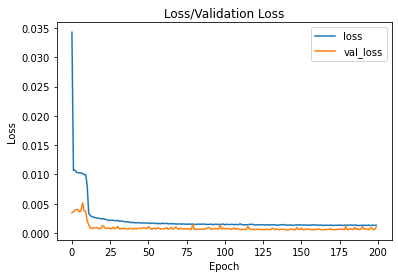

In [17]:
import numpy as np
import matplotlib.pyplot as plt


def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

    
def visualize_loss(history):
    plt.plot(history.history['mse'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss/Validation Loss')
    plt.legend(loc='upper right')
    plt.pause(0.001)
    plt.show()
    
def visualize_predict(real_data, predict_data, model_name="LSTM"):
    plt.figure(figsize=(16,6))
    plt.plot(real_data, label='True Value')
    plt.plot(predict_data, label='Predict Value')
    plt.title('Prediction by' + model_name)
    plt.xlabel('Time Scale')
    plt.ylabel('Scaled USD')
    plt.legend()
    plt.show()
visualize_loss(history)

### Display result

Text(0, 0.5, 'IBM Closing Return')

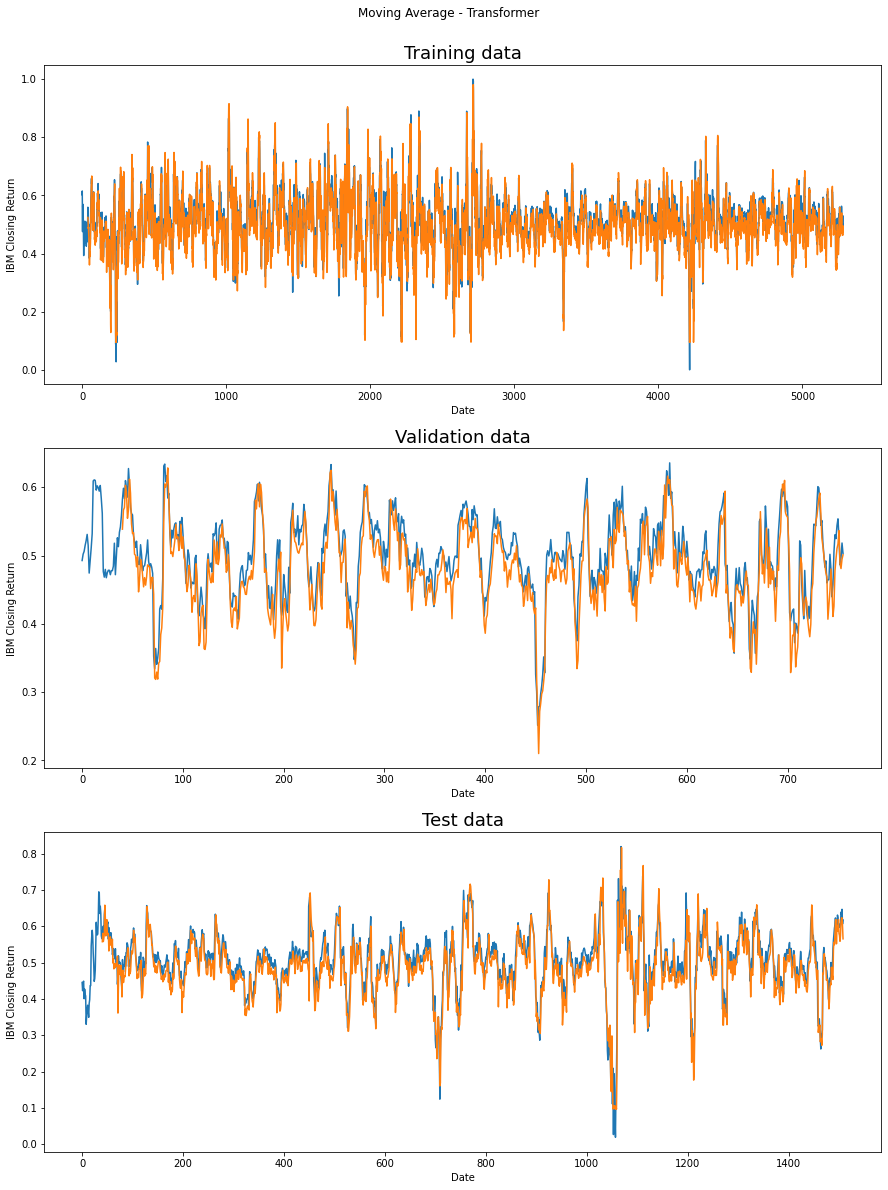

In [18]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)
val_pred = model.predict(x_validation)
fig = plt.figure(figsize=(15, 20))
st = fig.suptitle("Moving Average - Transformer")
st.set_y(0.92)

# Plot training data
ax11 = fig.add_subplot(311)
ax11.plot(train_scaled[:, 3], label="IBM Closing Returns")
ax11.plot(np.arange(TIME_STEPS, train_pred.shape[0]+ TIME_STEPS), train_pred, label="Predicted IBM closing return")
ax11.set_title("Training data", fontsize=18)
ax11.set_xlabel("Date")
ax11.set_ylabel("IBM Closing Return")

# Plot validation data
ax11 = fig.add_subplot(312)
ax11.plot(val_scaled[:, 3], label="IBM Closing Returns")
ax11.plot(np.arange(TIME_STEPS, val_pred.shape[0]+ TIME_STEPS), val_pred, label="Predicted IBM closing return")
ax11.set_title("Validation data", fontsize=18)
ax11.set_xlabel("Date")
ax11.set_ylabel("IBM Closing Return")

# Plot test data
ax11 = fig.add_subplot(313)
ax11.plot(test_scaled[:, 3], label="IBM Closing Returns")
ax11.plot(np.arange(TIME_STEPS, test_pred.shape[0]+ TIME_STEPS), test_pred, label="Predicted IBM closing return")
ax11.set_title("Test data", fontsize=18)
ax11.set_xlabel("Date")
ax11.set_ylabel("IBM Closing Return")